In [2]:

import pandas as pd
import numpy as np
import ast
import matplotlib.pyplot as plt
import seaborn as sns
from kneed import KneeLocator
import prince
from kmodes.kmodes import KModes

In [3]:
archivoOrg = "data/gen/cleaned.csv"
df = pd.read_csv(archivoOrg)
df.head(20)

,ANO_EMISION,MES_EMISION,DIA_EMISION,REG_MCPIO,QUIEN_REPORTA,VIC_SEXO,VIC_EDAD,TOTAL_HIJOS,NUM_HIJ_HOM,NUM_HIJ_MUJ,...,AGR_OTROS_N_OS,AGR_OTRAS_N_AS,INST_DENUN_HECHO,LEY_APLICABLE,FECHA_EMISION,FECHA_HECHO,REG_DPTO,HEC_DPTO,MEDIDAS_SEGURIDAD,CONTEXTO_DE_VIC
0,2013,1,22,guatemala,Víctima,Mujeres,38.0,2,1,1,...,0.0,0.0,Organismo Judicial,Ambas leyes (VIF y VCM),2013-01-22,2013-01-19,guatemala,guatemala,Dto. 22-2008,2
1,2013,1,24,guatemala,Víctima,Mujeres,20.0,1,0,1,...,99.0,99.0,Ministerio Público,NaN,2013-01-24,2013-01-23,guatemala,guatemala,Dto. 22-2008,2
2,2013,1,21,guatemala,Víctima,Mujeres,21.0,2,1,1,...,99.0,99.0,Procuraduría de los Derechos Humanos,NaN,2013-01-21,2013-01-21,guatemala,guatemala,Dto. 22-2008,1
3,2013,1,2,guatemala,Víctima,Hombres,70.0,0,0,0,...,99.0,99.0,Procuraduría de los Derechos Humanos,NaN,2013-01-02,2013-01-02,guatemala,guatemala,Dto. 97-96,3
4,2013,1,10,guatemala,Víctima,Mujeres,36.0,99,99,99,...,99.0,99.0,Procuraduría de los Derechos Humanos,NaN,2013-01-10,2013-01-10,guatemala,guatemala,Dto. 22-2008,2
5,2013,1,15,guatemala,Víctima,Mujeres,56.0,0,0,0,...,99.0,99.0,Procuraduría de los Derechos Humanos,NaN,2013-01-15,2013-01-15,guatemala,guatemala,Dto. 22-2008,0
6,2013,1,11,guatemala,Víctima,Mujeres,42.0,99,99,99,...,99.0,99.0,Procuraduría de los Derechos Humanos,NaN,2013-01-11,2013-01-11,guatemala,guatemala,Dto. 22-2008,1
7,2013,1,11,guatemala,Víctima,Mujeres,33.0,0,0,0,...,99.0,99.0,Procuraduría de los Derechos Humanos,NaN,2013-01-11,2013-01-11,guatemala,guatemala,Dto. 22-2008,0
8,2013,1,2,guatemala,Víctima,Mujeres,46.0,1,0,1,...,99.0,99.0,Procuraduría de los Derechos Humanos,NaN,2013-01-02,2013-01-01,guatemala,guatemala,Dto. 22-2008,1
9,2013,1,3,guatemala,Víctima,Mujeres,42.0,99,99,99,...,99.0,99.0,Procuraduría de los Derechos Humanos,NaN,2013-01-03,2013-01-03,guatemala,guatemala,Dto. 22-2008,1


In [4]:
df['FECHA_EMISION'] = pd.to_datetime(df['FECHA_EMISION'])
df['FECHA_HECHO'] = pd.to_datetime(df['FECHA_HECHO'])
df['DAYS_DIFF'] = (df['FECHA_EMISION'] - df['FECHA_HECHO']).dt.days

def categorize_date_diff(days_diff):
    if days_diff == 0:
        return 'Mismo día'
    elif 1 <= days_diff <= 7:
        return 'Dentro de la primera semana'
    elif 8 <= days_diff <= 30:
        return 'Dentro del primer mes'
    elif 31 <= days_diff <= 365:
        return 'Dentro del primer año'
    elif days_diff > 365:
        return 'Más de un año'
    else:
        return 'Fecha de emisión anterior a fecha del hecho'

df['FECHA_ENTRE_EMISION_HECHO'] = df['DAYS_DIFF'].apply(categorize_date_diff)

# Eliminamos la columna 'DAYS_DIFF' si ya no es necesaria
df.drop(columns=['DAYS_DIFF'], inplace=True)

In [5]:
nuevas_columnas = [
    'VIC_REL_AGR', 'HEC_TIPAGRE', 'CONTEXTO_DE_VIC', 'MEDIDAS_SEGURIDAD', 
    'FECHA_ENTRE_EMISION_HECHO', 'TOTAL_HIJOS', 'NUM_HIJ_HOM', 
    'NUM_HIJ_MUJ', 'OTRAS_VICTIMAS', 'VIC_OTRAS_HOM', 'VIC_OTRAS_MUJ', 
    'VIC_OTRAS_N_OS', 'VIC_OTRAS_N_AS', 'AGRESORES_OTROS_TOTAL', 
    'AGR_OTROS_HOM', 'AGR_OTRAS_MUJ', 'AGR_OTROS_N_OS', 'AGR_OTRAS_N_AS', 'HEC_RECUR_DENUN'
]
df['HEC_TIPAGRE'] = df['HEC_TIPAGRE'].apply(ast.literal_eval)
nuevo_df = df[nuevas_columnas].copy()
nuevo_df.head()

,VIC_REL_AGR,HEC_TIPAGRE,CONTEXTO_DE_VIC,MEDIDAS_SEGURIDAD,FECHA_ENTRE_EMISION_HECHO,TOTAL_HIJOS,NUM_HIJ_HOM,NUM_HIJ_MUJ,OTRAS_VICTIMAS,VIC_OTRAS_HOM,VIC_OTRAS_MUJ,VIC_OTRAS_N_OS,VIC_OTRAS_N_AS,AGRESORES_OTROS_TOTAL,AGR_OTROS_HOM,AGR_OTRAS_MUJ,AGR_OTROS_N_OS,AGR_OTRAS_N_AS,HEC_RECUR_DENUN
0,Esposos(a),"[física, psicológica]",2,Dto. 22-2008,Dentro de la primera semana,2,1,1,0,0.0,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0,No
1,Conviviente,"[física, psicológica, patrimonial]",2,Dto. 22-2008,Dentro de la primera semana,1,0,1,99,99.0,99.0,99.0,99.0,99,99.0,99.0,99.0,99.0,No
2,Ex-cónyuges,"[física, psicológica, patrimonial]",1,Dto. 22-2008,Mismo día,2,1,1,2,0.0,0.0,1.0,1.0,99,99.0,99.0,99.0,99.0,No
3,Esposos(a),[psicológica],3,Dto. 97-96,Mismo día,0,0,0,0,0.0,0.0,0.0,0.0,99,99.0,99.0,99.0,99.0,No
4,Esposos(a),"[psicológica, sexual, patrimonial]",2,Dto. 22-2008,Mismo día,99,99,99,1,0.0,0.0,1.0,0.0,99,99.0,99.0,99.0,99.0,No


In [6]:
df_exploded = df.explode('HEC_TIPAGRE')

dummies = pd.get_dummies(df_exploded['HEC_TIPAGRE'], prefix='TipoAgre')

df_exploded = df_exploded.join(dummies)

df_final = df_exploded.groupby(df_exploded.index)[dummies.columns].max(numeric_only=False)


cols = ['VIC_REL_AGR', 'CONTEXTO_DE_VIC', 'MEDIDAS_SEGURIDAD', 
                     'FECHA_ENTRE_EMISION_HECHO', 'TOTAL_HIJOS', 'NUM_HIJ_HOM', 
                     'NUM_HIJ_MUJ', 'OTRAS_VICTIMAS', 'VIC_OTRAS_HOM', 'VIC_OTRAS_MUJ', 
                     'VIC_OTRAS_N_OS', 'VIC_OTRAS_N_AS', 'AGRESORES_OTROS_TOTAL', 
                     'AGR_OTROS_HOM', 'AGR_OTRAS_MUJ', 'AGR_OTROS_N_OS', 'AGR_OTRAS_N_AS','HEC_RECUR_DENUN']

for col in cols:
    df_final[col] = df.loc[df.index.isin(df_final.index), col]

df_final = df_final[[*cols, *dummies.columns]]
df_final.head()

,VIC_REL_AGR,CONTEXTO_DE_VIC,MEDIDAS_SEGURIDAD,FECHA_ENTRE_EMISION_HECHO,TOTAL_HIJOS,NUM_HIJ_HOM,NUM_HIJ_MUJ,OTRAS_VICTIMAS,VIC_OTRAS_HOM,VIC_OTRAS_MUJ,...,AGRESORES_OTROS_TOTAL,AGR_OTROS_HOM,AGR_OTRAS_MUJ,AGR_OTROS_N_OS,AGR_OTRAS_N_AS,HEC_RECUR_DENUN,TipoAgre_física,TipoAgre_patrimonial,TipoAgre_psicológica,TipoAgre_sexual
0,Esposos(a),2,Dto. 22-2008,Dentro de la primera semana,2,1,1,0,0.0,0.0,...,0,0.0,0.0,0.0,0.0,No,True,False,True,False
1,Conviviente,2,Dto. 22-2008,Dentro de la primera semana,1,0,1,99,99.0,99.0,...,99,99.0,99.0,99.0,99.0,No,True,True,True,False
2,Ex-cónyuges,1,Dto. 22-2008,Mismo día,2,1,1,2,0.0,0.0,...,99,99.0,99.0,99.0,99.0,No,True,True,True,False
3,Esposos(a),3,Dto. 97-96,Mismo día,0,0,0,0,0.0,0.0,...,99,99.0,99.0,99.0,99.0,No,False,False,True,False
4,Esposos(a),2,Dto. 22-2008,Mismo día,99,99,99,1,0.0,0.0,...,99,99.0,99.0,99.0,99.0,No,False,True,True,True


In [7]:
def convertir_columnas(valor):
    if valor == 0:
        return 'Si'
    elif valor > 0 and valor != 99:
        return 'No'
    elif valor == 99:
        return 'Desconocido'
    else:
        return valor

In [9]:

df_final['HAY_HIJOS'] = df_final['TOTAL_HIJOS'].apply(convertir_columnas)
df_final['HAY_HIJOS_HOM'] = df_final['NUM_HIJ_HOM'].apply(convertir_columnas)
df_final['HAY_HIJOS_MUJ'] = df_final['NUM_HIJ_MUJ'].apply(convertir_columnas)
df_final['HAY_OTRAS_VIC'] = df_final['OTRAS_VICTIMAS'].apply(convertir_columnas)
df_final['HAY_OTRAS_VIC_HOM_MENORES'] = df_final['VIC_OTRAS_N_OS'].apply(convertir_columnas)
df_final['HAY_OTRAS_VIC_MUJ_MENORES'] = df_final['VIC_OTRAS_N_AS'].apply(convertir_columnas)
df_final['HAY_OTROS_AGR'] = df_final['AGRESORES_OTROS_TOTAL'].apply(convertir_columnas)

columnas_originales = ['VIC_REL_AGR', 'CONTEXTO_DE_VIC', 'MEDIDAS_SEGURIDAD',
                       'FECHA_ENTRE_EMISION_HECHO', 'HEC_RECUR_DENUN',
                       'TipoAgre_física', 'TipoAgre_patrimonial',
                       'TipoAgre_psicológica', 'TipoAgre_sexual']

nuevo_df = df_final[['HAY_HIJOS', 'HAY_HIJOS_HOM', 'HAY_HIJOS_MUJ', 'HAY_OTRAS_VIC',
               'HAY_OTRAS_VIC_HOM_MENORES', 'HAY_OTRAS_VIC_MUJ_MENORES', 'HAY_OTROS_AGR'] + columnas_originales].copy()

nuevo_df.head()


,HAY_HIJOS,HAY_HIJOS_HOM,HAY_HIJOS_MUJ,HAY_OTRAS_VIC,HAY_OTRAS_VIC_HOM_MENORES,HAY_OTRAS_VIC_MUJ_MENORES,HAY_OTROS_AGR,VIC_REL_AGR,CONTEXTO_DE_VIC,MEDIDAS_SEGURIDAD,FECHA_ENTRE_EMISION_HECHO,HEC_RECUR_DENUN,TipoAgre_física,TipoAgre_patrimonial,TipoAgre_psicológica,TipoAgre_sexual
0,No,No,No,Si,Si,Si,Si,Esposos(a),2,Dto. 22-2008,Dentro de la primera semana,No,True,False,True,False
1,No,Si,No,Desconocido,Desconocido,Desconocido,Desconocido,Conviviente,2,Dto. 22-2008,Dentro de la primera semana,No,True,True,True,False
2,No,No,No,No,No,No,Desconocido,Ex-cónyuges,1,Dto. 22-2008,Mismo día,No,True,True,True,False
3,Si,Si,Si,Si,Si,Si,Desconocido,Esposos(a),3,Dto. 97-96,Mismo día,No,False,False,True,False
4,Desconocido,Desconocido,Desconocido,No,No,Si,Desconocido,Esposos(a),2,Dto. 22-2008,Mismo día,No,False,True,True,True


In [10]:
categoric_df = pd.DataFrame()
for column in nuevo_df.columns:
    categoric_df[column] = nuevo_df[column].astype('category')
    
categoric_df.head()

,HAY_HIJOS,HAY_HIJOS_HOM,HAY_HIJOS_MUJ,HAY_OTRAS_VIC,HAY_OTRAS_VIC_HOM_MENORES,HAY_OTRAS_VIC_MUJ_MENORES,HAY_OTROS_AGR,VIC_REL_AGR,CONTEXTO_DE_VIC,MEDIDAS_SEGURIDAD,FECHA_ENTRE_EMISION_HECHO,HEC_RECUR_DENUN,TipoAgre_física,TipoAgre_patrimonial,TipoAgre_psicológica,TipoAgre_sexual
0,No,No,No,Si,Si,Si,Si,Esposos(a),2,Dto. 22-2008,Dentro de la primera semana,No,True,False,True,False
1,No,Si,No,Desconocido,Desconocido,Desconocido,Desconocido,Conviviente,2,Dto. 22-2008,Dentro de la primera semana,No,True,True,True,False
2,No,No,No,No,No,No,Desconocido,Ex-cónyuges,1,Dto. 22-2008,Mismo día,No,True,True,True,False
3,Si,Si,Si,Si,Si,Si,Desconocido,Esposos(a),3,Dto. 97-96,Mismo día,No,False,False,True,False
4,Desconocido,Desconocido,Desconocido,No,No,Si,Desconocido,Esposos(a),2,Dto. 22-2008,Mismo día,No,False,True,True,True


In [11]:
data_matrix = categoric_df.apply(lambda x: x.cat.codes).values

### Metodo del Codo

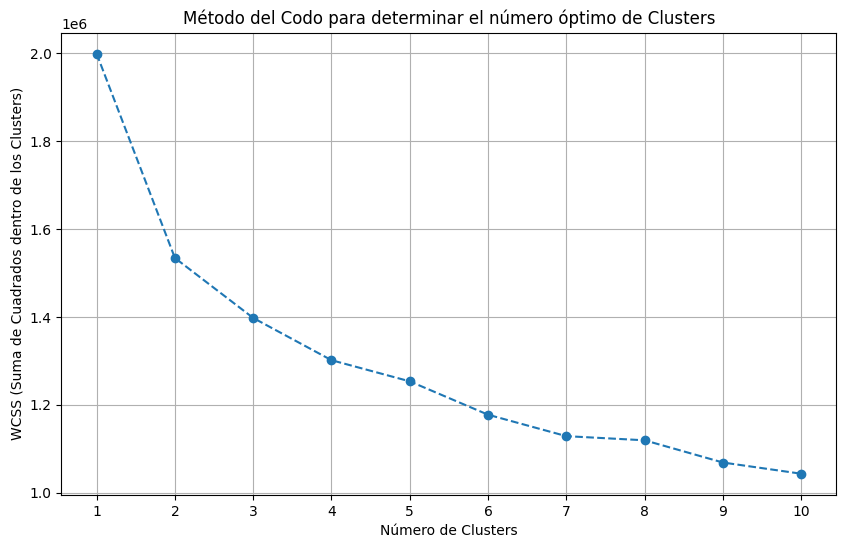


 La cantidad de clusteres debe ser 3


In [31]:
wcss = []
for i in range(1, 11):
    kmodes = KModes(n_clusters=i, init='Huang', n_init=5, verbose=0)
    kmodes.fit(data_matrix)
    wcss.append(kmodes.cost_)

plt.figure(figsize=(10, 6))
plt.plot(range(1, 11), wcss, marker='o', linestyle='--')
plt.xlabel('Número de Clusters')
plt.ylabel('WCSS (Suma de Cuadrados dentro de los Clusters)')
plt.title('Método del Codo para determinar el número óptimo de Clusters')
plt.xticks(np.arange(1, 11, 1))
plt.grid(True)
plt.show()    


localizador_codo = KneeLocator(range(1, 11), wcss, curve = 'convex', direction = "decreasing")
print(f"\n La cantidad de clusteres debe ser {localizador_codo.elbow}")

In [12]:
n_clusters = 3
kmodes = KModes(n_clusters=n_clusters, init='Huang', n_init=5, verbose=1)

# Ajusta el modelo a tus datos
clusters = kmodes.fit_predict(data_matrix)


Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 1, iteration: 1/100, moves: 99163, cost: 1390346.0
Run 1, iteration: 2/100, moves: 3550, cost: 1390346.0
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 2, iteration: 1/100, moves: 67109, cost: 1392412.0
Run 2, iteration: 2/100, moves: 25112, cost: 1392412.0
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 3, iteration: 1/100, moves: 60723, cost: 1462626.0
Run 3, iteration: 2/100, moves: 13552, cost: 1462626.0
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 4, iteration: 1/100, moves: 152996, cost: 1464815.0
Run 4, iteration: 2/100, moves: 58528, cost: 1384166.0
Run 4, iteration: 3/100, moves: 10007, cost: 1380995.0
Run 4, iteration: 4/100, moves: 2121, cost: 1380995.0
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 5, iteration: 1/100, moves: 52251, cost: 138150

In [13]:
categoric_df['Gauge Cluster'] = clusters
categoric_df.head()

,HAY_HIJOS,HAY_HIJOS_HOM,HAY_HIJOS_MUJ,HAY_OTRAS_VIC,HAY_OTRAS_VIC_HOM_MENORES,HAY_OTRAS_VIC_MUJ_MENORES,HAY_OTROS_AGR,VIC_REL_AGR,CONTEXTO_DE_VIC,MEDIDAS_SEGURIDAD,FECHA_ENTRE_EMISION_HECHO,HEC_RECUR_DENUN,TipoAgre_física,TipoAgre_patrimonial,TipoAgre_psicológica,TipoAgre_sexual,Gauge Cluster
0,No,No,No,Si,Si,Si,Si,Esposos(a),2,Dto. 22-2008,Dentro de la primera semana,No,True,False,True,False,0
1,No,Si,No,Desconocido,Desconocido,Desconocido,Desconocido,Conviviente,2,Dto. 22-2008,Dentro de la primera semana,No,True,True,True,False,1
2,No,No,No,No,No,No,Desconocido,Ex-cónyuges,1,Dto. 22-2008,Mismo día,No,True,True,True,False,0
3,Si,Si,Si,Si,Si,Si,Desconocido,Esposos(a),3,Dto. 97-96,Mismo día,No,False,False,True,False,0
4,Desconocido,Desconocido,Desconocido,No,No,Si,Desconocido,Esposos(a),2,Dto. 22-2008,Mismo día,No,False,True,True,True,2


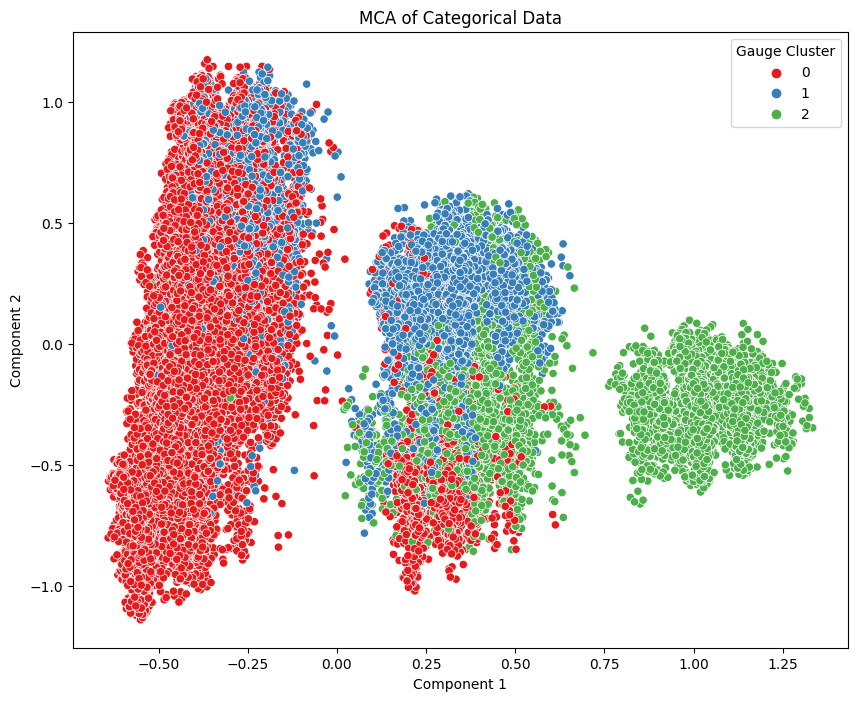

In [18]:
categorical_columns = categoric_df.columns[:-1]

mca = prince.MCA(n_components=3, n_iter=3, copy=True, check_input=True, engine='sklearn')
mca = mca.fit(categoric_df[categorical_columns])

mca_transformed = mca.transform(categoric_df[categorical_columns])

df_mca = pd.concat([categoric_df, mca_transformed], axis=1)


plt.figure(figsize=(10, 8))
sns.scatterplot(data=df_mca, x=0, y=1, hue='Gauge Cluster', palette='Set1')
plt.title('MCA of Categorical Data')
plt.xlabel('Component 1')
plt.ylabel('Component 2')
plt.show()


/var/folders/2s/j3vn9g1d48b630yqb51x1d740000gn/T/ipykernel_35009/3424145310.py:7: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  counts = df.groupby([cluster_col, column]).size().unstack().fillna(0)
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/seaborn/categorical.py:641: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped_vals = vals.groupby(grouper)
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/seaborn/categorical.py:641: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. P

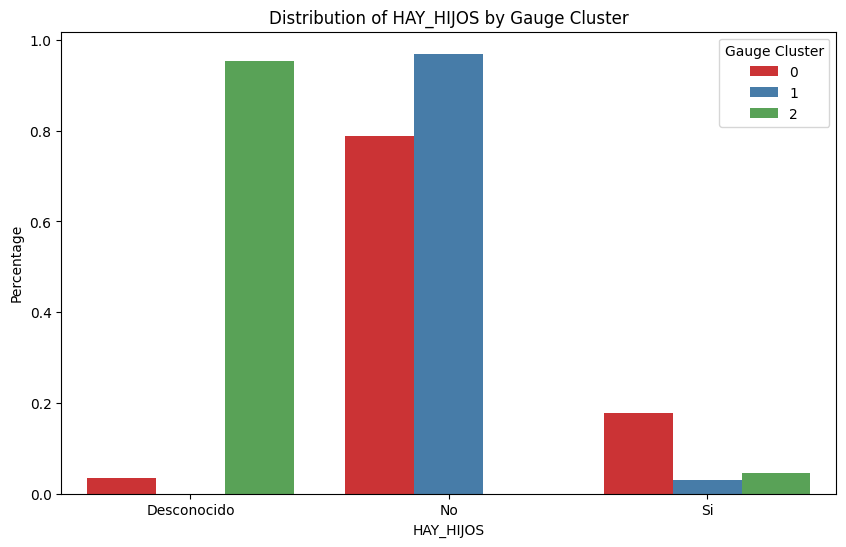

/var/folders/2s/j3vn9g1d48b630yqb51x1d740000gn/T/ipykernel_35009/3424145310.py:7: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  counts = df.groupby([cluster_col, column]).size().unstack().fillna(0)
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/seaborn/categorical.py:641: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped_vals = vals.groupby(grouper)
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/seaborn/categorical.py:641: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. P

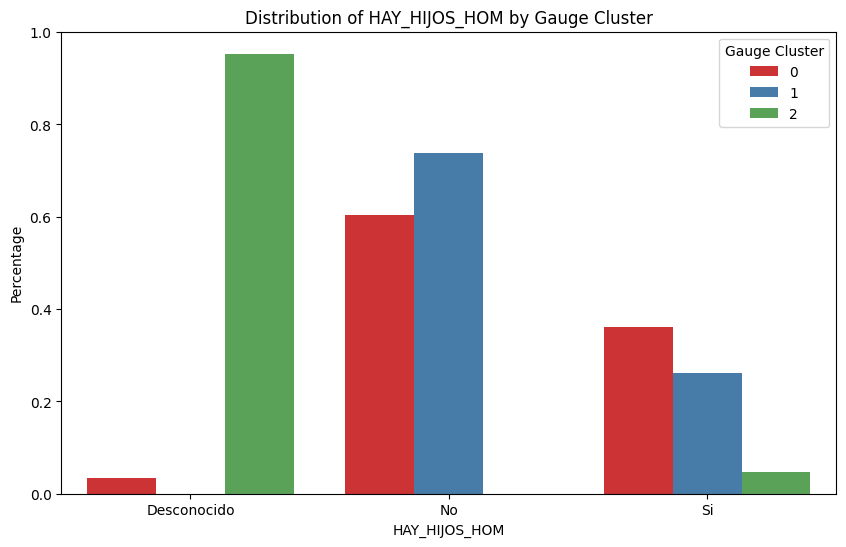

/var/folders/2s/j3vn9g1d48b630yqb51x1d740000gn/T/ipykernel_35009/3424145310.py:7: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  counts = df.groupby([cluster_col, column]).size().unstack().fillna(0)
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/seaborn/categorical.py:641: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped_vals = vals.groupby(grouper)
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/seaborn/categorical.py:641: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. P

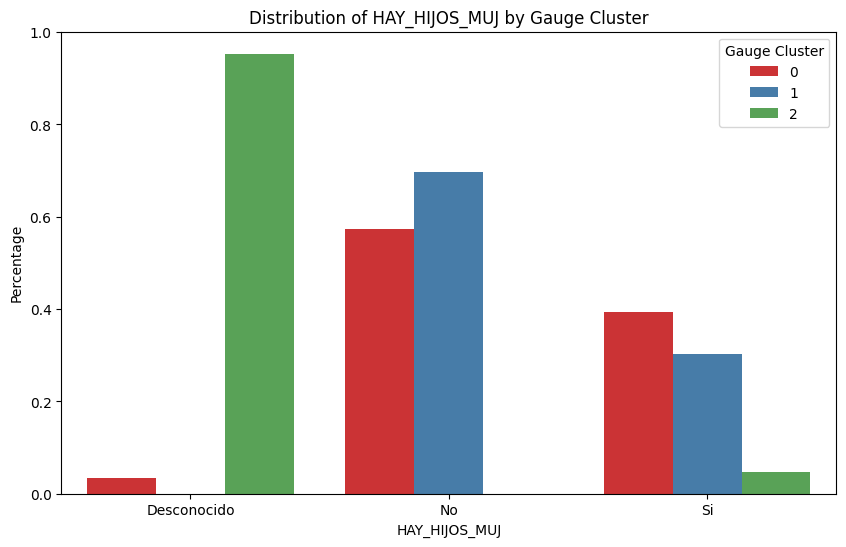

/var/folders/2s/j3vn9g1d48b630yqb51x1d740000gn/T/ipykernel_35009/3424145310.py:7: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  counts = df.groupby([cluster_col, column]).size().unstack().fillna(0)
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/seaborn/categorical.py:641: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped_vals = vals.groupby(grouper)
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/seaborn/categorical.py:641: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. P

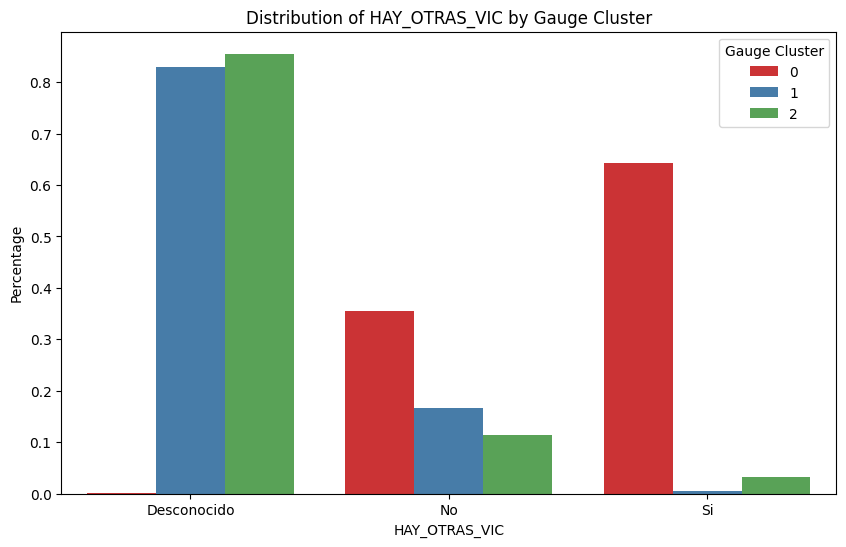

/var/folders/2s/j3vn9g1d48b630yqb51x1d740000gn/T/ipykernel_35009/3424145310.py:7: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  counts = df.groupby([cluster_col, column]).size().unstack().fillna(0)
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/seaborn/categorical.py:641: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped_vals = vals.groupby(grouper)
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/seaborn/categorical.py:641: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. P

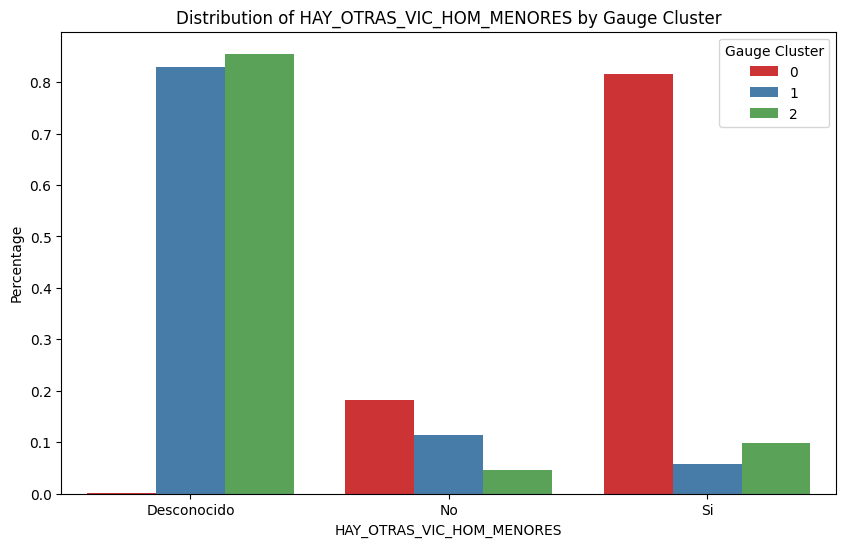

/var/folders/2s/j3vn9g1d48b630yqb51x1d740000gn/T/ipykernel_35009/3424145310.py:7: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  counts = df.groupby([cluster_col, column]).size().unstack().fillna(0)
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/seaborn/categorical.py:641: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped_vals = vals.groupby(grouper)
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/seaborn/categorical.py:641: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. P

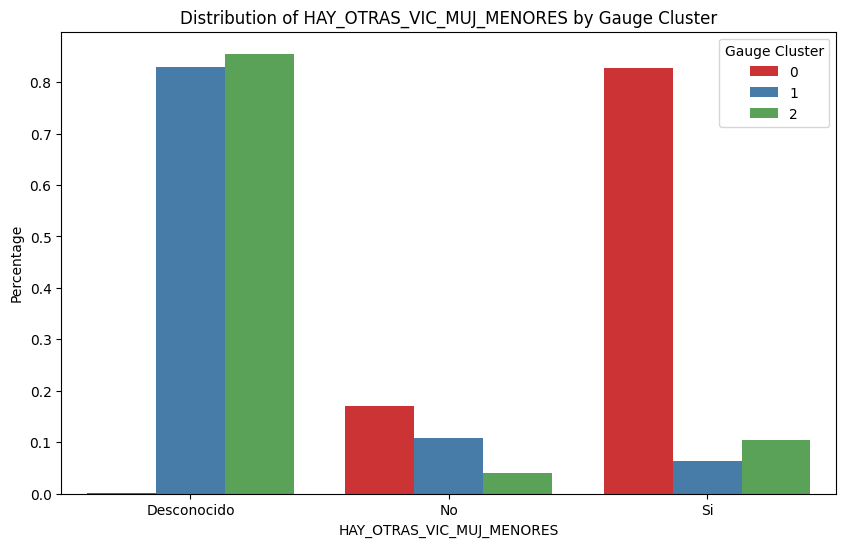

/var/folders/2s/j3vn9g1d48b630yqb51x1d740000gn/T/ipykernel_35009/3424145310.py:7: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  counts = df.groupby([cluster_col, column]).size().unstack().fillna(0)
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/seaborn/categorical.py:641: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped_vals = vals.groupby(grouper)
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/seaborn/categorical.py:641: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. P

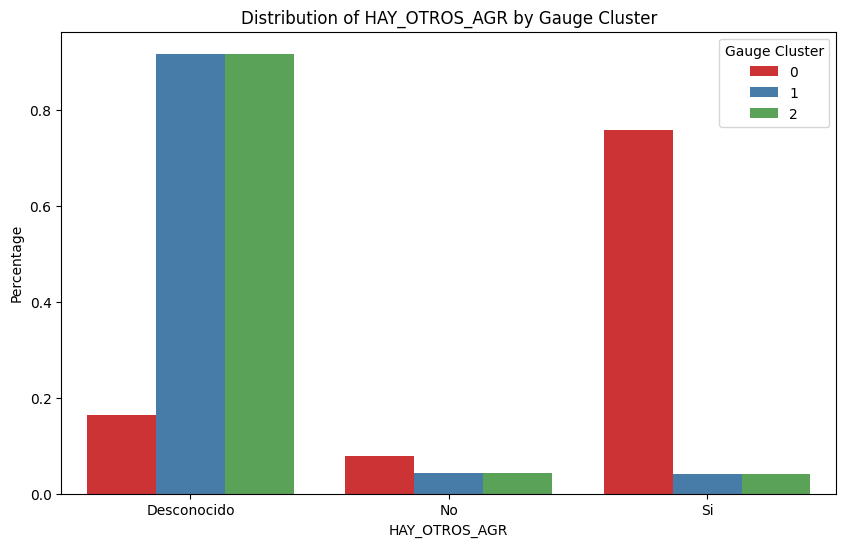

/var/folders/2s/j3vn9g1d48b630yqb51x1d740000gn/T/ipykernel_35009/3424145310.py:7: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  counts = df.groupby([cluster_col, column]).size().unstack().fillna(0)
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/seaborn/categorical.py:641: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped_vals = vals.groupby(grouper)
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/seaborn/categorical.py:641: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. P

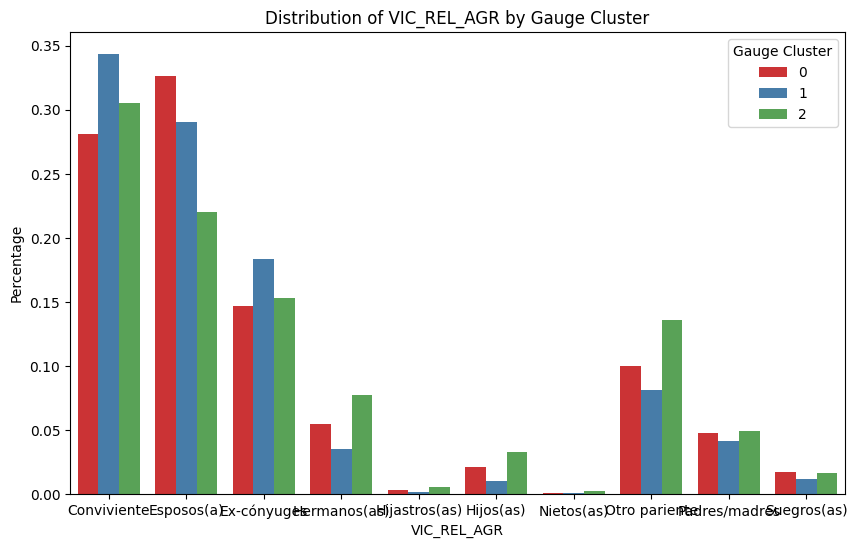

/var/folders/2s/j3vn9g1d48b630yqb51x1d740000gn/T/ipykernel_35009/3424145310.py:7: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  counts = df.groupby([cluster_col, column]).size().unstack().fillna(0)
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/seaborn/categorical.py:641: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped_vals = vals.groupby(grouper)
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/seaborn/categorical.py:641: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. P

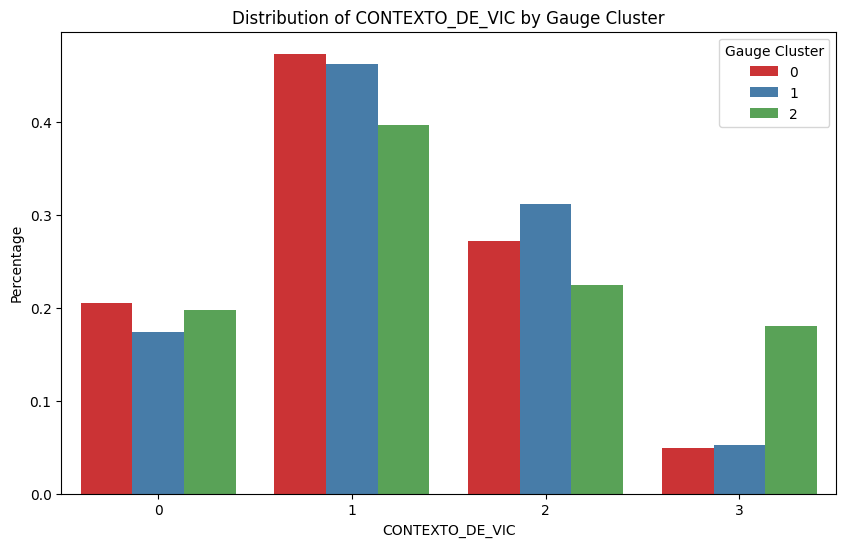

/var/folders/2s/j3vn9g1d48b630yqb51x1d740000gn/T/ipykernel_35009/3424145310.py:7: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  counts = df.groupby([cluster_col, column]).size().unstack().fillna(0)
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/seaborn/categorical.py:641: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped_vals = vals.groupby(grouper)
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/seaborn/categorical.py:641: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. P

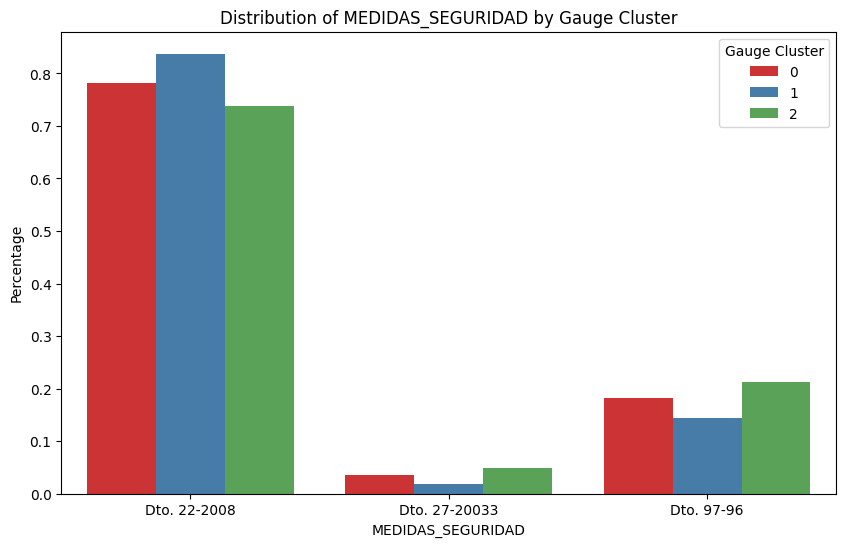

/var/folders/2s/j3vn9g1d48b630yqb51x1d740000gn/T/ipykernel_35009/3424145310.py:7: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  counts = df.groupby([cluster_col, column]).size().unstack().fillna(0)
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/seaborn/categorical.py:641: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped_vals = vals.groupby(grouper)
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/seaborn/categorical.py:641: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. P

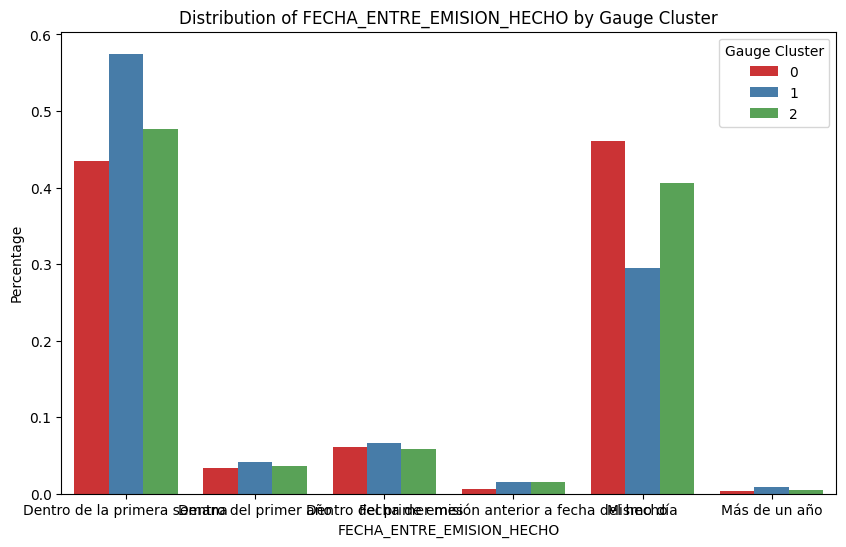

/var/folders/2s/j3vn9g1d48b630yqb51x1d740000gn/T/ipykernel_35009/3424145310.py:7: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  counts = df.groupby([cluster_col, column]).size().unstack().fillna(0)
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/seaborn/categorical.py:641: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped_vals = vals.groupby(grouper)
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/seaborn/categorical.py:641: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. P

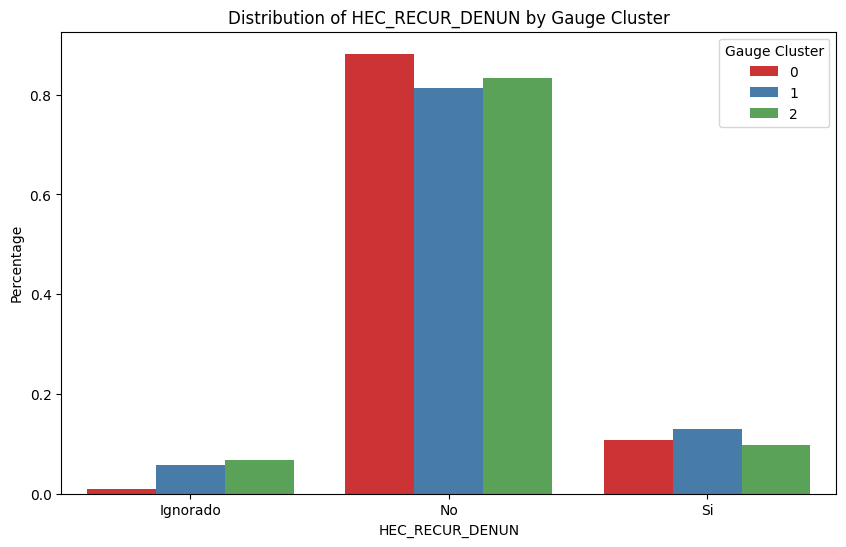

/var/folders/2s/j3vn9g1d48b630yqb51x1d740000gn/T/ipykernel_35009/3424145310.py:7: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  counts = df.groupby([cluster_col, column]).size().unstack().fillna(0)
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/seaborn/categorical.py:641: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped_vals = vals.groupby(grouper)
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/seaborn/categorical.py:641: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. P

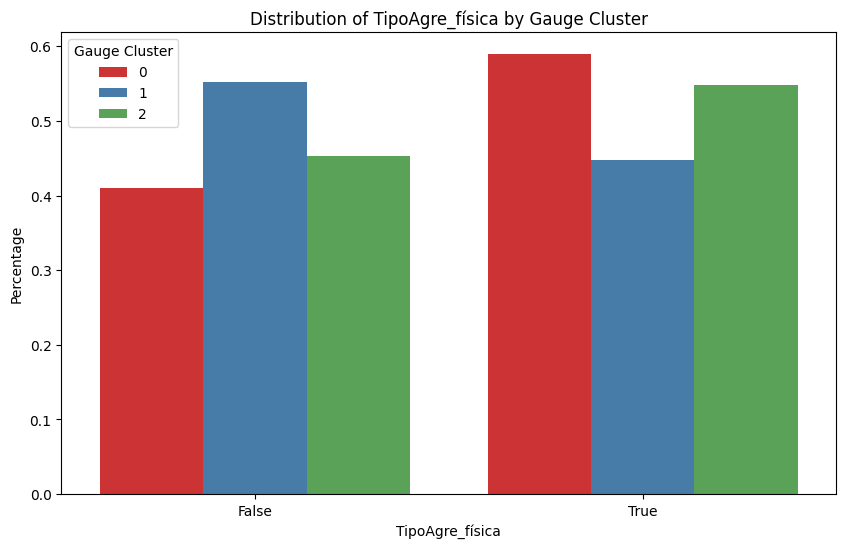

/var/folders/2s/j3vn9g1d48b630yqb51x1d740000gn/T/ipykernel_35009/3424145310.py:7: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  counts = df.groupby([cluster_col, column]).size().unstack().fillna(0)
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/seaborn/categorical.py:641: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped_vals = vals.groupby(grouper)
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/seaborn/categorical.py:641: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. P

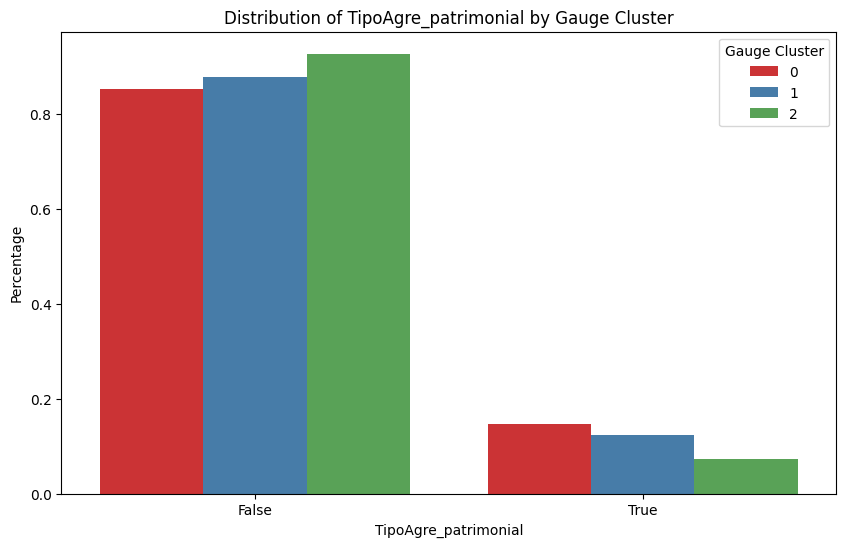

/var/folders/2s/j3vn9g1d48b630yqb51x1d740000gn/T/ipykernel_35009/3424145310.py:7: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  counts = df.groupby([cluster_col, column]).size().unstack().fillna(0)
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/seaborn/categorical.py:641: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped_vals = vals.groupby(grouper)
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/seaborn/categorical.py:641: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. P

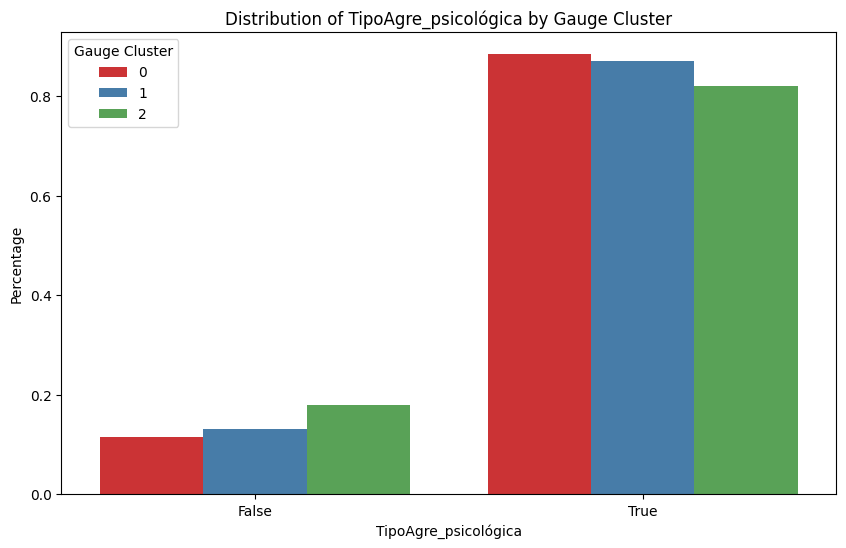

/var/folders/2s/j3vn9g1d48b630yqb51x1d740000gn/T/ipykernel_35009/3424145310.py:7: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  counts = df.groupby([cluster_col, column]).size().unstack().fillna(0)
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/seaborn/categorical.py:641: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped_vals = vals.groupby(grouper)
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/seaborn/categorical.py:641: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. P

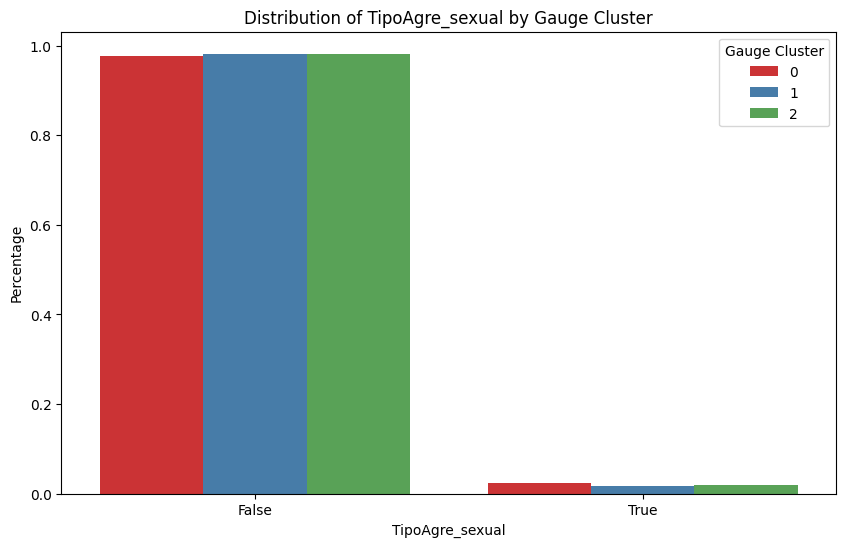

In [20]:
import seaborn as sns
import matplotlib.pyplot as plt

# Función para crear gráficos de barras con porcentajes para cada columna categórica
def plot_categorical_distribution(df, column, cluster_col='Gauge Cluster'):
    # Calculamos el porcentaje de cada categoría dentro de cada cluster
    counts = df.groupby([cluster_col, column]).size().unstack().fillna(0)
    percentages = counts.div(counts.sum(axis=1), axis=0).stack().reset_index(name='percentage')
    
    # Creamos el gráfico
    plt.figure(figsize=(10, 6))
    sns.barplot(data=percentages, x=column, y='percentage', hue=cluster_col, palette='Set1')
    plt.title(f'Distribution of {column} by {cluster_col}')
    plt.xlabel(column)
    plt.ylabel('Percentage')
    plt.legend(title=cluster_col)
    plt.show()

categorical_columns = categoric_df.columns[:-1]

# Creamos gráficos de barras para cada columna categórica
for col in categorical_columns:
    plot_categorical_distribution(categoric_df, col)


In [22]:
categoric_df['HEC_TIPAGRE'] = df['HEC_TIPAGRE']

# Analisis de Clusters

## Cluster 0

In [53]:
cluster_0 = categoric_df[categoric_df['Gauge Cluster'] == 0]
total_cases = cluster_0.count()[0]

print(f"Hay {total_cases} casos en el Cluster 0, este es el {total_cases/len(categoric_df.index) *100} % de los casos \n") 

for columna in cluster_0.columns:
    if not columna == 'HEC_TIPAGRE':
        value_counts = cluster_0[columna].value_counts()
        percentages = (value_counts / total_cases) * 100

        print(f"Columna: {columna}")
        for value, count in value_counts.items():
            print(f"{value}: {count} casos ({percentages[value]:.2f}%)")
        print("\n")
    else:
        value_counts = cluster_0['HEC_TIPAGRE'].value_counts()
        percentages = (value_counts / total_cases) * 100
        print(f"Columna: {columna}")
        keys = value_counts.keys()
        for i in range(len(value_counts)):
            print(f"{keys[i]}: {value_counts[i]} casos ({percentages[i]:.2f}%)")
        print("\n")


Hay 175179 casos en el Cluster 0, este es el 54.78144212547454 % de los casos 

Columna: HAY_HIJOS
No: 138183 casos (78.88%)
Si: 31045 casos (17.72%)
Desconocido: 5951 casos (3.40%)


Columna: HAY_HIJOS_HOM
No: 105792 casos (60.39%)
Si: 63436 casos (36.21%)
Desconocido: 5951 casos (3.40%)


Columna: HAY_HIJOS_MUJ
No: 100336 casos (57.28%)
Si: 68894 casos (39.33%)
Desconocido: 5949 casos (3.40%)


Columna: HAY_OTRAS_VIC
Si: 112594 casos (64.27%)
No: 62204 casos (35.51%)
Desconocido: 381 casos (0.22%)


Columna: HAY_OTRAS_VIC_HOM_MENORES
Si: 143049 casos (81.66%)
No: 31749 casos (18.12%)
Desconocido: 381 casos (0.22%)


Columna: HAY_OTRAS_VIC_MUJ_MENORES
Si: 145033 casos (82.79%)
No: 29765 casos (16.99%)
Desconocido: 381 casos (0.22%)


Columna: HAY_OTROS_AGR
Si: 132863 casos (75.84%)
Desconocido: 28699 casos (16.38%)
No: 13617 casos (7.77%)


Columna: VIC_REL_AGR
Esposos(a): 57135 casos (32.62%)
Conviviente: 49226 casos (28.10%)
Ex-cónyuges: 25702 casos (14.67%)
Otro pariente: 17581 cas

/var/folders/2s/j3vn9g1d48b630yqb51x1d740000gn/T/ipykernel_35009/1138193681.py:2: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  total_cases = cluster_0.count()[0]
/var/folders/2s/j3vn9g1d48b630yqb51x1d740000gn/T/ipykernel_35009/1138193681.py:21: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  print(f"{keys[i]}: {value_counts[i]} casos ({percentages[i]:.2f}%)")


El cluster 0 contiene la mayor proporción de casos, siendo esta el 54.78% de los casos, estos casos no involucran casos donde la victima principal, no tiene hijos pero si hay multiples victimas implicadas en la denuncia y en su mayoria involucran menores de edad, al mismo tiempo hay multiples agresores. 

Las relaciones prevalentes en estas denuncias entre victima y agresor son de esposo(a), convivientes y Ex-conyuges. Estas denuncias son realizadas en 46% de los casos en el mismo dia y en 43% de los casos dentro de la primera semana. No son casos de recurrencia.

Estas agresiones son principalmente por casos de agresion fisica y violencia psicologica, mas del 98% de los casos involucran violencia fisica, psicologica o ambas.

## Cluster 1


In [52]:
cluster_1 = categoric_df[categoric_df['Gauge Cluster'] == 1]
total_cases = cluster_1.count()[0]

print(f"Hay {total_cases} casos en el Cluster 1 este es el {total_cases/len(categoric_df.index) *100} % de los casos \n")

for columna in cluster_1.columns:
    if not columna == 'HEC_TIPAGRE':
        value_counts = cluster_1[columna].value_counts()
        percentages = (value_counts / total_cases) * 100

        print(f"Columna: {columna}")
        for value, count in value_counts.items():
            print(f"{value}: {count} casos ({percentages[value]:.2f}%)")
        print("\n")
    else:
        value_counts = cluster_1['HEC_TIPAGRE'].value_counts()
        percentages = (value_counts / total_cases) * 100
        print(f"Columna: {columna}")
        keys = value_counts.keys()
        for i in range(len(value_counts)):
            print(f"{keys[i]}: {value_counts[i]} casos ({percentages[i]:.2f}%)")
        print("\n")
        
        print("\n")
        


Hay 89032 casos en el Cluster 1 este es el 27.841815259336165 % de los casos 

Columna: HAY_HIJOS
No: 86341 casos (96.98%)
Si: 2691 casos (3.02%)
Desconocido: 0 casos (0.00%)


Columna: HAY_HIJOS_HOM
No: 65803 casos (73.91%)
Si: 23229 casos (26.09%)
Desconocido: 0 casos (0.00%)


Columna: HAY_HIJOS_MUJ
No: 61997 casos (69.63%)
Si: 27035 casos (30.37%)
Desconocido: 0 casos (0.00%)


Columna: HAY_OTRAS_VIC
Desconocido: 73781 casos (82.87%)
No: 14785 casos (16.61%)
Si: 466 casos (0.52%)


Columna: HAY_OTRAS_VIC_HOM_MENORES
Desconocido: 73781 casos (82.87%)
No: 10096 casos (11.34%)
Si: 5155 casos (5.79%)


Columna: HAY_OTRAS_VIC_MUJ_MENORES
Desconocido: 73781 casos (82.87%)
No: 9650 casos (10.84%)
Si: 5601 casos (6.29%)


Columna: HAY_OTROS_AGR
Desconocido: 81586 casos (91.64%)
No: 3752 casos (4.21%)
Si: 3694 casos (4.15%)


Columna: VIC_REL_AGR
Conviviente: 30574 casos (34.34%)
Esposos(a): 25860 casos (29.05%)
Ex-cónyuges: 16322 casos (18.33%)
Otro pariente: 7227 casos (8.12%)
Padres/madr

/var/folders/2s/j3vn9g1d48b630yqb51x1d740000gn/T/ipykernel_35009/2111493601.py:2: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  total_cases = cluster_1.count()[0]
/var/folders/2s/j3vn9g1d48b630yqb51x1d740000gn/T/ipykernel_35009/2111493601.py:22: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  print(f"{keys[i]}: {value_counts[i]} casos ({percentages[i]:.2f}%)")


El cluster 1 contiene el 27.84% de los casos, estos casos no involucran victimas con hijos ni otras victimas en la denuncia, tampoco involucran otros agresores.

Las relaciones prevalentes en estas denuncias entre victima y agresor son de convivientes, esposo(a) y Ex-conyuges. Estas denuncias son realizadas dentro de la misma semana en 57.49% de los casos y el mismo dia en 29.43%. No son casos de recurrencia.

Estas agresiones son principalmente por casos de violencia psicologica, siendo esta presente en 87% de los casos y 46.45% de los casos unicamente involucran violencia psicologica. Este es el cluster que menor cantidad de casos de violencia sexual contiene.

## Cluster 2

In [54]:
cluster_2 = categoric_df[categoric_df['Gauge Cluster'] == 2]
total_cases = cluster_2.count()[0]

print(f"Hay {total_cases} casos en el Cluster 2 este es el {total_cases/len(categoric_df.index) *100} % de los casos \n")

for columna in cluster_2.columns:
    if not columna == 'HEC_TIPAGRE':
        value_counts = cluster_2[columna].value_counts()
        percentages = (value_counts / total_cases) * 100

        print(f"Columna: {columna}")
        for value, count in value_counts.items():
            print(f"{value}: {count} casos ({percentages[value]:.2f}%)")
        print("\n")
    else:
        value_counts = cluster_2['HEC_TIPAGRE'].value_counts()
        percentages = (value_counts / total_cases) * 100
        print(f"Columna: {columna}")
        keys = value_counts.keys()
        for i in range(len(value_counts)):
            print(f"{keys[i]}: {value_counts[i]} casos ({percentages[i]:.2f}%)")
        print("\n")


Hay 55567 casos en el Cluster 2 este es el 17.376742615189286 % de los casos 

Columna: HAY_HIJOS
Desconocido: 52970 casos (95.33%)
Si: 2597 casos (4.67%)
No: 0 casos (0.00%)


Columna: HAY_HIJOS_HOM
Desconocido: 52970 casos (95.33%)
Si: 2597 casos (4.67%)
No: 0 casos (0.00%)


Columna: HAY_HIJOS_MUJ
Desconocido: 52965 casos (95.32%)
Si: 2602 casos (4.68%)
No: 0 casos (0.00%)


Columna: HAY_OTRAS_VIC
Desconocido: 47515 casos (85.51%)
No: 6289 casos (11.32%)
Si: 1763 casos (3.17%)


Columna: HAY_OTRAS_VIC_HOM_MENORES
Desconocido: 47515 casos (85.51%)
Si: 5459 casos (9.82%)
No: 2593 casos (4.67%)


Columna: HAY_OTRAS_VIC_MUJ_MENORES
Desconocido: 47515 casos (85.51%)
Si: 5768 casos (10.38%)
No: 2284 casos (4.11%)


Columna: HAY_OTROS_AGR
Desconocido: 50861 casos (91.53%)
No: 2450 casos (4.41%)
Si: 2256 casos (4.06%)


Columna: VIC_REL_AGR
Conviviente: 16988 casos (30.57%)
Esposos(a): 12232 casos (22.01%)
Ex-cónyuges: 8530 casos (15.35%)
Otro pariente: 7551 casos (13.59%)
Hermanos(as): 428

/var/folders/2s/j3vn9g1d48b630yqb51x1d740000gn/T/ipykernel_35009/3569910556.py:2: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  total_cases = cluster_2.count()[0]
/var/folders/2s/j3vn9g1d48b630yqb51x1d740000gn/T/ipykernel_35009/3569910556.py:21: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  print(f"{keys[i]}: {value_counts[i]} casos ({percentages[i]:.2f}%)")


El cluster 2 contiene el 17.37% de los casos, estos casos no involucran victimas con hijos ni otras victimas en la denuncia, tampoco involucran otros agresores.

Las relaciones prevalentes en estas denuncias entre victima y agresor son de convivientes, esposo(a) y Ex-conyuges. Estas denuncias son realizadas dentro de la misma semana en 47.70% de los casos y el mismo dia en 40.64%. No son casos de recurrencia.

Estas agresiones son principalmente por casos de violencia fisica y psicologica, siendo esta presente en 87% de los casos y 46.45% de los casos unicamente involucran violencia psicologica. Este es el cluster que menor cantidad de casos de violencia sexual contiene.

In [55]:
categoric_df.to_csv('data/gen/indicator_with_clusters.csv', index=False)

In [63]:
combined_df = pd.concat([df, categoric_df], axis=1)
combined_df['GAUGE_CLUSTER'] = combined_df['Gauge Cluster']
combined_df.drop(columns=['Gauge Cluster'])
combined_df.head()

,ANO_EMISION,MES_EMISION,DIA_EMISION,REG_MCPIO,QUIEN_REPORTA,VIC_SEXO,VIC_EDAD,TOTAL_HIJOS,NUM_HIJ_HOM,NUM_HIJ_MUJ,...,MEDIDAS_SEGURIDAD,FECHA_ENTRE_EMISION_HECHO,HEC_RECUR_DENUN,TipoAgre_física,TipoAgre_patrimonial,TipoAgre_psicológica,TipoAgre_sexual,Gauge Cluster,HEC_TIPAGRE,GAUGE_CLUSTER
0,2013,1,22,guatemala,Víctima,Mujeres,38.0,2,1,1,...,Dto. 22-2008,Dentro de la primera semana,No,True,False,True,False,0,"[física, psicológica]",0
1,2013,1,24,guatemala,Víctima,Mujeres,20.0,1,0,1,...,Dto. 22-2008,Dentro de la primera semana,No,True,True,True,False,1,"[física, psicológica, patrimonial]",1
2,2013,1,21,guatemala,Víctima,Mujeres,21.0,2,1,1,...,Dto. 22-2008,Mismo día,No,True,True,True,False,0,"[física, psicológica, patrimonial]",0
3,2013,1,2,guatemala,Víctima,Hombres,70.0,0,0,0,...,Dto. 97-96,Mismo día,No,False,False,True,False,0,[psicológica],0
4,2013,1,10,guatemala,Víctima,Mujeres,36.0,99,99,99,...,Dto. 22-2008,Mismo día,No,False,True,True,True,2,"[psicológica, sexual, patrimonial]",2


In [64]:
combined_df.to_csv('data/gen/combined_with_clusters.csv', index=False)